In [ ]:

# Spotify Popularity - LGBM + multi-XGB + multi-RF + ExtraTrees + Blending

!pip -q install lightgbm xgboost category-encoders tqdm

import inspect
from sklearn.base import clone

import numpy as np
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV

from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
# 1) Load and basic cleaning
train = pd.read_csv("spotify_train_data.csv")
test  = pd.read_csv("spotify_test_data.csv")

# Remove Kaggle index column if exists
for df in (train, test):
    if "#" in df.columns:
        df.drop(columns=["#"], inplace=True)

# Save row_id for final submission
row_ids = test["row_id"] if "row_id" in test.columns else pd.Series(range(len(test)), name="row_id")

target_col = "popularity"
assert target_col in train.columns, "Training set missing 'popularity' column."

y = train[target_col].astype("float32")
X = train.drop(columns=[target_col, "row_id"], errors="ignore").copy()
X_test = test.drop(columns=["row_id"], errors="ignore").copy()


# 2) Lightweight + extended feature engineering

def add_feature_block(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Convert all numeric columns to float32
    for c in out.columns:
        if pd.api.types.is_numeric_dtype(out[c]):
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("float32")

    # duration in seconds & log
    if "duration_ms" in out.columns:
        out["duration_sec"] = (out["duration_ms"] / 1000).astype("float32")
        out["duration_log"] = np.log1p(out["duration_sec"]).astype("float32")

    # tempo log
    if "tempo" in out.columns:
        out["tempo_log"] = np.log1p(out["tempo"]).astype("float32")

    # interaction: dance × energy
    if {"danceability","energy"}.issubset(out.columns):
        out["dance_energy"] = (out["danceability"] * out["energy"]).astype("float32")

    # key as cyclic feature
    if "key" in out.columns:
        out["key"] = pd.to_numeric(out["key"], errors="coerce").astype("float32")
        out["key_sin"] = np.sin(2*np.pi*out["key"]/12).astype("float32")
        out["key_cos"] = np.cos(2*np.pi*out["key"]/12).astype("float32")

    # Additional energy-related features (simple but often useful)
    if {"energy","acousticness"}.issubset(out.columns):
        out["energy_minus_acoustic"] = (out["energy"] - out["acousticness"]).astype("float32")
    if {"valence","energy"}.issubset(out.columns):
        out["valence_plus_energy"] = (out["valence"] + out["energy"]).astype("float32")
    if {"speechiness","energy"}.issubset(out.columns):
        out["speech_x_energy"] = (out["speechiness"] * out["energy"]).astype("float32")
    if {"valence","danceability"}.issubset(out.columns):
        out["valence_x_dance"] = (out["valence"] * out["danceability"]).astype("float32")

    return out

X = add_feature_block(X)
X_test = add_feature_block(X_test)

# Select feature columns (missing columns will be filled with NaN)
numeric_cols = [
    'duration_sec','duration_log',
    'danceability','energy','loudness','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','tempo_log',
    'dance_energy','key_sin','key_cos',
    # newly added 4 interactions
    'energy_minus_acoustic','valence_plus_energy','speech_x_energy','valence_x_dance'
]
low_card_cats = ['explicit','mode','time_signature']
high_card_cats = ['track_genre']

for c in numeric_cols + low_card_cats + high_card_cats:
    if c not in X.columns:
        X[c] = np.nan
        X_test[c] = np.nan


# 3) Fold-wise preprocessing (to avoid leakage)

num_imputer = SimpleImputer(strategy="median")

from typing import Tuple

def prepare_fold_matrices(
    X_tr: pd.DataFrame, X_val: pd.DataFrame, X_te: pd.DataFrame, y_tr: pd.Series
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Copy to avoid modifying original data
    X_tr = X_tr.copy(); X_val = X_val.copy(); X_te = X_te.copy()

    # Target encoding (only for high-cardinality categorical columns)
    if high_card_cats:
        te = TargetEncoder(cols=high_card_cats, smoothing=0.3)
        X_tr[high_card_cats] = te.fit_transform(X_tr[high_card_cats], y_tr)
        X_val[high_card_cats] = te.transform(X_val[high_card_cats])
        X_te[high_card_cats]  = te.transform(X_te[high_card_cats])

    # Low-card categorical -> numeric float32
    for c in low_card_cats:
        X_tr[c]  = pd.to_numeric(X_tr[c], errors="coerce").astype("float32")
        X_val[c] = pd.to_numeric(X_val[c], errors="coerce").astype("float32")
        X_te[c]  = pd.to_numeric(X_te[c], errors="coerce").astype("float32")

    # Combine final feature list
    used_cols = numeric_cols + low_card_cats + high_card_cats

    # Missing value imputation (numeric only)
    X_tr_mat = num_imputer.fit_transform(X_tr[used_cols])
    X_val_mat= num_imputer.transform(X_val[used_cols])
    X_te_mat = num_imputer.transform(X_te[used_cols])

    X_tr_mat = X_tr_mat.astype("float32")
    X_val_mat= X_val_mat.astype("float32")
    X_te_mat = X_te_mat.astype("float32")

    return X_tr_mat, X_val_mat, X_te_mat


In [ ]:
# 4) Base parameters for three (+1) models

lgb_params = dict(
    n_estimators=4000,
    learning_rate=0.01,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1
)

xgb_params = dict(
    n_estimators=10000,
    max_depth=8,
    learning_rate=0.01,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=1.0,
    tree_method="hist",
    n_jobs=-1,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=SEED
)

rf_params = dict(
    n_estimators=1000,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=SEED
)

et_params = dict(
    n_estimators=800,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=SEED
)

# Multiple seeds for ensembling (you can adjust number of seeds)
xgb_seeds = [42, 2024]      # multiple XGB models with different seeds
rf_seeds  = [42, 2024]      # multiple RF models with different seeds
et_seeds  = [42]            # one ExtraTrees model is enough to start


In [ ]:
# 5) Single-model OOF training function (with early stopping)

def train_oof_model(
    base_model_name: str,
    base_model,
    X: pd.DataFrame,
    y: pd.Series,
    X_test: pd.DataFrame,
    n_splits: int = 5
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(X.shape[0], dtype="float32")
    test_pred = np.zeros(X_test.shape[0], dtype="float32")

    for fold, (tr_idx, val_idx) in enumerate(tqdm(kf.split(X, y), total=n_splits, desc=f"{base_model_name}")):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        # —— Fold-wise preprocessing (includes Target Encoding, avoids leakage) ——
        X_tr_mat, X_val_mat, X_te_mat = prepare_fold_matrices(X_tr, X_val, X_test, y_tr)

        # Clone a fresh model
        model = clone(base_model)

        # ============== Training ==============
        if isinstance(model, LGBMRegressor):
            # LightGBM: stable early stopping support
            model.fit(
                X_tr_mat, y_tr,
                eval_set=[(X_val_mat, y_val)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
            )

        elif isinstance(model, XGBRegressor):
            # XGBoost: adaptive depending on version — use early stopping if available
            fit_sig = inspect.signature(model.fit).parameters

            if "early_stopping_rounds" in fit_sig:
                model.fit(
                    X_tr_mat, y_tr,
                    eval_set=[(X_val_mat, y_val)],
                    early_stopping_rounds=100,
                    verbose=False
                )
            elif "callbacks" in fit_sig:
                try:
                    model.fit(
                        X_tr_mat, y_tr,
                        eval_set=[(X_val_mat, y_val)],
                        callbacks=[EarlyStopping(rounds=100, save_best=True, maximize=False)],
                        verbose=False
                    )
                except Exception:
                    model.fit(X_tr_mat, y_tr, verbose=False)
            else:
                model.fit(X_tr_mat, y_tr, verbose=False)

        else:
            # RandomForest / ExtraTrees — no early stopping available
            model.fit(X_tr_mat, y_tr)

        # ============== Prediction ==============
        oof[val_idx] = model.predict(X_val_mat).astype("float32")
        test_pred += model.predict(X_te_mat).astype("float32") / n_splits

    r2 = r2_score(y, oof)
    print(f"{base_model_name} OOF R² = {r2:.6f}")
    return oof, test_pred


# 6) Multi-seed training version (bagging on the same algorithm)

def train_oof_multi(
    base_name: str,
    model_cls,
    base_params: dict,
    seeds: List[int],
    X: pd.DataFrame,
    y: pd.Series,
    X_test: pd.DataFrame,
    n_splits: int = 5
):
    oof_list = []
    test_list = []
    for s in seeds:
        params = base_params.copy()
        params["random_state"] = s
        print(f"\n=== {base_name} with seed={s} ===")
        oof_s, test_s = train_oof_model(f"{base_name}_seed{s}", model_cls(**params), X, y, X_test, n_splits=n_splits)
        oof_list.append(oof_s)
        test_list.append(test_s)
    oof_mean = np.mean(oof_list, axis=0)
    test_mean = np.mean(test_list, axis=0)
    print(f"\n{base_name} multi-seed OOF R² = {r2_score(y, oof_mean):.6f}")
    return oof_mean, test_mean


In [ ]:
# 7) Train all base models

print("\n--- Training base models with 5-fold OOF ---")

# LGBM single model
oof_lgb,  pred_lgb  = train_oof_model("LGBM", LGBMRegressor(**lgb_params), X, y, X_test, n_splits=5)

# XGB with multiple seeds
oof_xgb,  pred_xgb  = train_oof_multi("XGB", XGBRegressor, xgb_params, xgb_seeds, X, y, X_test, n_splits=5)

# RandomForest with multiple seeds
oof_rf,   pred_rf   = train_oof_multi("RF",  RandomForestRegressor, rf_params, rf_seeds, X, y, X_test, n_splits=5)

# ExtraTrees (using single seed for now; can switch to multi-seed if desired)
oof_et,   pred_et   = train_oof_multi("ET",  ExtraTreesRegressor,  et_params, et_seeds, X, y, X_test, n_splits=5)



--- Training base models with 5-fold OOF ---


LGBM:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4483
[LightGBM] [Info] Number of data points in the train set: 68400, number of used features: 23
[LightGBM] [Info] Start training from score 33.206857


LGBM:  20%|██        | 1/5 [01:33<06:14, 93.71s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 68400, number of used features: 23
[LightGBM] [Info] Start training from score 33.197266


LGBM:  40%|████      | 2/5 [03:37<05:34, 111.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4483
[LightGBM] [Info] Number of data points in the train set: 68400, number of used features: 23
[LightGBM] [Info] Start training from score 33.202398


LGBM:  60%|██████    | 3/5 [06:00<04:11, 125.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4483
[LightGBM] [Info] Number of data points in the train set: 68400, number of used features: 23
[LightGBM] [Info] Start training from score 33.174693


LGBM:  80%|████████  | 4/5 [07:24<01:49, 109.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 68400, number of used features: 23
[LightGBM] [Info] Start training from score 33.143173


LGBM: 100%|██████████| 5/5 [08:49<00:00, 105.84s/it]


LGBM OOF R² = 0.516206

=== XGB with seed=42 ===


XGB_seed42: 100%|██████████| 5/5 [22:42<00:00, 272.52s/it]


XGB_seed42 OOF R² = 0.573823

=== XGB with seed=2024 ===


XGB_seed2024: 100%|██████████| 5/5 [22:40<00:00, 272.13s/it]


XGB_seed2024 OOF R² = 0.573378

XGB multi-seed OOF R² = 0.574567

=== RF with seed=42 ===


RF_seed42: 100%|██████████| 5/5 [28:40<00:00, 344.14s/it]


RF_seed42 OOF R² = 0.508494

=== RF with seed=2024 ===


RF_seed2024: 100%|██████████| 5/5 [28:45<00:00, 345.07s/it]


RF_seed2024 OOF R² = 0.508307

RF multi-seed OOF R² = 0.508662

=== ET with seed=42 ===


ET_seed42: 100%|██████████| 5/5 [07:37<00:00, 91.54s/it]


ET_seed42 OOF R² = 0.513703

ET multi-seed OOF R² = 0.513703


In [ ]:
et_seeds = [42, 2024]           # switch to multiple seeds for ExtraTrees
oof_et, pred_et = train_oof_multi(
    "ET", ExtraTreesRegressor, et_params, et_seeds, X, y, X_test, n_splits=5
)



=== ET with seed=42 ===


ET_seed42: 100%|██████████| 5/5 [07:48<00:00, 93.70s/it]


ET_seed42 OOF R² = 0.513703

=== ET with seed=2024 ===


ET_seed2024: 100%|██████████| 5/5 [07:42<00:00, 92.43s/it]

ET_seed2024 OOF R² = 0.512942

ET multi-seed OOF R² = 0.513548


In [ ]:
!pip -q install catboost
from catboost import CatBoostRegressor, Pool

# 1) Prepare data for CatBoost: use the same add_feature_block on the raw X
X_cb = add_feature_block(train.drop(columns=[target_col, "row_id"], errors="ignore"))
X_test_cb = add_feature_block(test.drop(columns=["row_id"], errors="ignore"))

# 2) Explicitly specify which columns are categorical, and convert types to int or str as needed
cat_cols_cb = []
for col in ["track_genre", "key", "time_signature", "explicit", "mode"]:
    if col in X_cb.columns:
        if col == "track_genre":
            # ensure string type
            X_cb[col] = X_cb[col].astype("str")
            X_test_cb[col] = X_test_cb[col].astype("str")
        else:
            # these are numeric-coded categorical columns: convert → fill -1 → cast to int
            X_cb[col] = pd.to_numeric(X_cb[col], errors="coerce").fillna(-1).astype(int)
            X_test_cb[col] = pd.to_numeric(X_test_cb[col], errors="coerce").fillna(-1).astype(int)
        cat_cols_cb.append(col)

# retrieve categorical column indices for CatBoost
cat_idx_cb = [X_cb.columns.get_loc(c) for c in cat_cols_cb]
print("CatBoost categorical cols:", cat_cols_cb)
print("CatBoost categorical idx:", cat_idx_cb)

# 3) 5-fold OOF training for CatBoost
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
oof_cb   = np.zeros(X_cb.shape[0], dtype="float32")
pred_cb  = np.zeros(X_test_cb.shape[0], dtype="float32")

for fold, (tr_idx, val_idx) in enumerate(tqdm(kf.split(X_cb, y), total=5, desc="CatBoost")):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx_cb)
    val_pool   = Pool(X_val, y_val, cat_features=cat_idx_cb)
    test_pool  = Pool(X_test_cb,      cat_features=cat_idx_cb)

    cb = CatBoostRegressor(
        depth=8,
        learning_rate=0.03,
        iterations=8000,           # large upper bound; effective stopping relies on early stopping
        loss_function="RMSE",
        eval_metric="RMSE",
        random_seed=SEED,
        od_type="Iter",
        od_wait=200,               # stop if no improvement for 200 rounds
        verbose=False,
        allow_writing_files=False
    )

    cb.fit(train_pool, eval_set=val_pool, use_best_model=True)

    oof_cb[val_idx] = cb.predict(val_pool).astype("float32")
    pred_cb += cb.predict(test_pool).astype("float32") / 5

print("CatBoost OOF R² =", r2_score(y, oof_cb))


CatBoost categorical cols: ['track_genre', 'key', 'time_signature', 'explicit', 'mode']
CatBoost categorical idx: [15, 5, 14, 2, 7]


CatBoost: 100%|██████████| 5/5 [1:13:42<00:00, 884.46s/it]

CatBoost OOF R² = 0.5051873326301575


In [ ]:

# 8) Blending with RidgeCV on OOF predictions

print("\n--- Blending with RidgeCV on OOF ---")
oof_stack  = np.vstack([oof_lgb,  oof_xgb,  oof_rf,  oof_et]).T  # (n_samples, 4)
test_stack = np.vstack([pred_lgb, pred_xgb, pred_rf, pred_et]).T # (n_test, 4)

ridge = RidgeCV(alphas=np.logspace(-3, 2, 30))
ridge.fit(oof_stack, y)
oof_blend = ridge.predict(oof_stack)

print("Weights (LGBM, XGB_ms, RF_ms, ET_ms):", ridge.coef_)
print(f"Blended OOF R² = {r2_score(y, oof_blend):.6f}")




--- Blending with RidgeCV on OOF ---


NameError: name 'np' is not defined

In [ ]:

# 9) Final prediction and submission

test_blend = ridge.predict(test_stack).astype("float32")
test_blend = np.clip(test_blend, 0, 100)

submission = pd.DataFrame({"row_id": row_ids, "popularity": test_blend})
submission.to_csv("submission_0911_cat.csv", index=False)
print("\n✅ Saved -> submission_0911_cat.csv")
submission.head()


✅ Saved -> submission_0911_cat.csv


,row_id,popularity
0,85500,27.216753
1,85501,44.350609
2,85502,14.739129
3,85503,51.816689
4,85504,34.203182


In [ ]:
from scipy.optimize import nnls

# Current OOF prediction matrix (4 base models)
oof_stack  = np.vstack([oof_lgb,  oof_xgb,  oof_rf,  oof_et]).T
test_stack = np.vstack([pred_lgb, pred_xgb, pred_rf, pred_et]).T

# 1) Non-negative least squares (weights >= 0)
w_nn, _ = nnls(oof_stack, y.values.astype(float))  # y is a pandas Series

# Normalizing the weights makes interpretation clearer (optional)
w_nn_norm = w_nn / (w_nn.sum() + 1e-12)

print("NNLS raw weights (LGBM, XGB_ms, RF_ms, ET_ms):", w_nn)
print("NNLS normalized weights:", w_nn_norm)

oof_blend_nn = oof_stack.dot(w_nn_norm)
print("Blended OOF R² (NNLS, non-negative) =", r2_score(y, oof_blend_nn))

# 2) Apply NNLS weights to test predictions
test_blend_nn = test_stack.dot(w_nn_norm).astype("float32")

# Clip prediction to valid range (Spotify popularity is 0–100)
test_blend_nn = np.clip(test_blend_nn, 0, 100)

sub_nn = pd.DataFrame({"row_id": row_ids, "popularity": test_blend_nn})
sub_nn.to_csv("submission_nnls.csv", index=False)
print("✅ Saved -> submission_nnls.csv")


NNLS raw weights (LGBM, XGB_ms, RF_ms, ET_ms): [0.         1.01077526 0.         0.00303639]
NNLS normalized weights: [0.         0.99700497 0.         0.00299503]
Blended OOF R² (NNLS, non-negative) = 0.5745586354342946
✅ Saved -> submission_nnls.csv


In [ ]:
#  XGB_ms + ET_ms
oof_two  = np.vstack([oof_xgb,  oof_et]).T
test_two = np.vstack([pred_xgb, pred_et]).T

ridge_two = RidgeCV(alphas=np.logspace(-3, 2, 30))
ridge_two.fit(oof_two, y)
oof_two_blend = ridge_two.predict(oof_two)
print("2-model Ridge weights (XGB_ms, ET_ms):", ridge_two.coef_)
print("2-model Blend OOF R² =", r2_score(y, oof_two_blend))

test_two_blend = ridge_two.predict(test_two).astype("float32")
test_two_blend = np.clip(test_two_blend, 0, 100)

sub_two = pd.DataFrame({"row_id": row_ids, "popularity": test_two_blend})
sub_two.to_csv("submission_xgb_et.csv", index=False)
print("✅ Saved -> submission_xgb_et.csv")


2-model Ridge weights (XGB_ms, ET_ms): [0.98310511 0.05797126]
2-model Blend OOF R² = 0.5753391997870876
✅ Saved -> submission_xgb_et.csv


In [8]:
import matplotlib.pyplot as plt


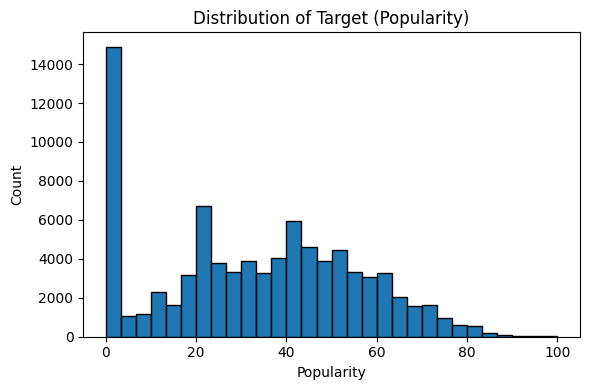

In [ ]:
# popularity distribution
plt.figure(figsize=(6,4))
plt.hist(train["popularity"], bins=30, edgecolor="k")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.title("Distribution of Target (Popularity)")
plt.tight_layout()
plt.show()


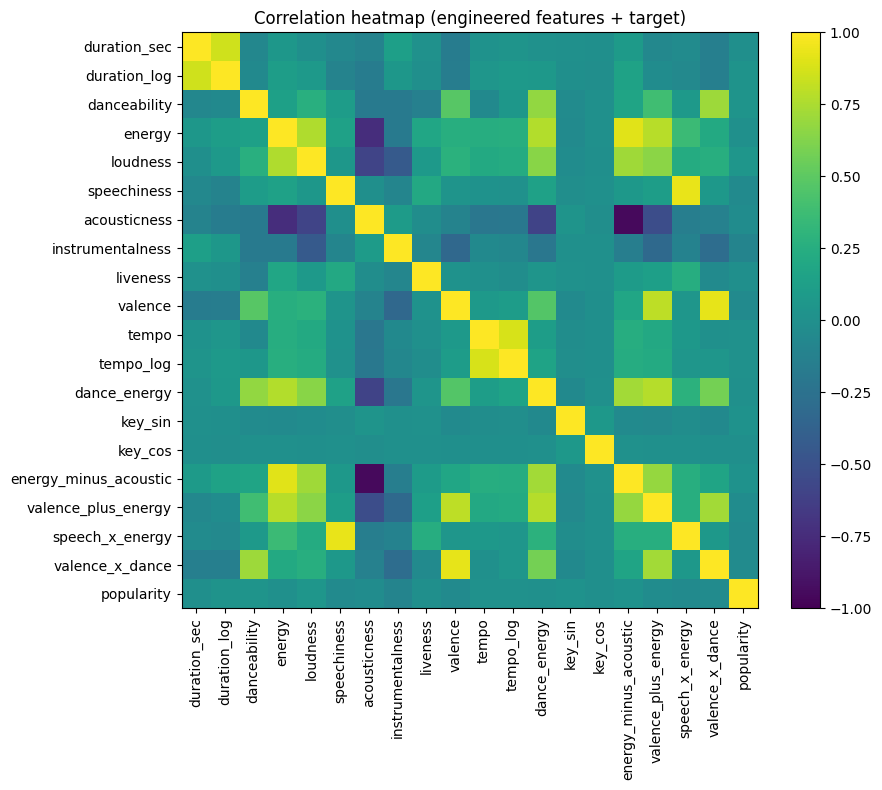

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Combine X features and target for correlation analysis
data_for_corr = X.copy()
data_for_corr["popularity"] = y.values


num_cols_for_corr = [c for c in numeric_cols if c in data_for_corr.columns] + ["popularity"]

corr = data_for_corr[num_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols_for_corr)), num_cols_for_corr, rotation=90)
plt.yticks(range(len(num_cols_for_corr)), num_cols_for_corr)
plt.title("Correlation heatmap (engineered features + target)")
plt.tight_layout()
plt.show()


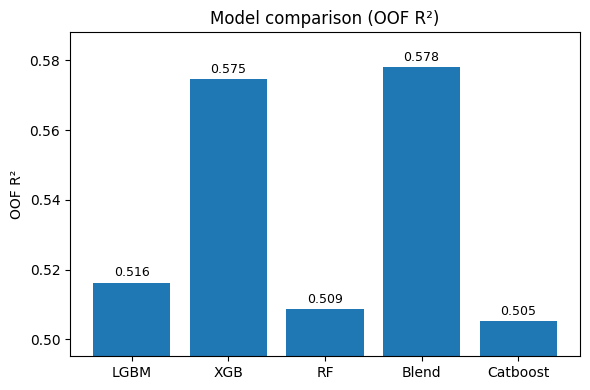

In [ ]:
# Model comparison (OOF R²)
r2_lgb   = r2_score(y, oof_lgb)
r2_xgb   = r2_score(y, oof_xgb)
r2_rf    = r2_score(y, oof_rf)
r2_blend = r2_score(y, oof_blend)
r2_cb = r2_score(y, oof_cb)

models = ["LGBM", "XGB", "RF", "Blend", "Catboost"]
scores = [r2_lgb, r2_xgb, r2_rf, r2_blend, r2_cb]

plt.figure(figsize=(6,4))
plt.bar(models, scores)
plt.ylabel("OOF R²")
plt.title("Model comparison (OOF R²)")
plt.ylim(min(scores)-0.01, max(scores)+0.01)
for i,s in enumerate(scores):
    plt.text(i, s+0.001, f"{s:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


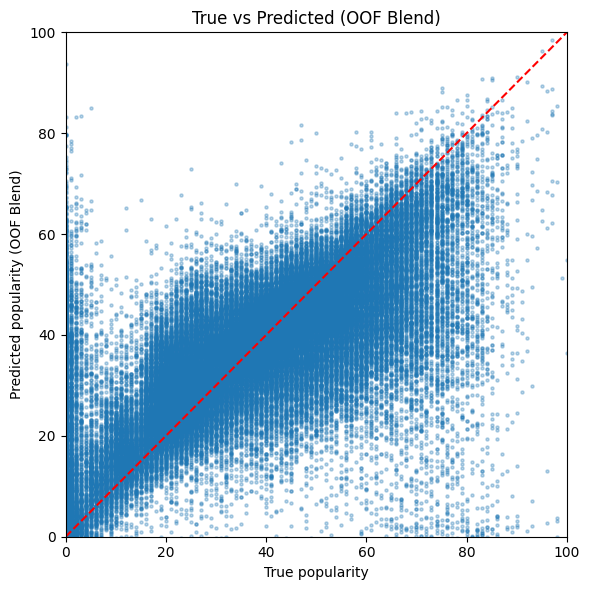

In [ ]:
# True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y, oof_blend, s=5, alpha=0.3)
plt.plot([0,100],[0,100], "r--")
plt.xlabel("True popularity")
plt.ylabel("Predicted popularity (OOF Blend)")
plt.title("True vs Predicted (OOF Blend)")
plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()
plt.show()


In [ ]:
# 1) Obtain the full feature matrix using the same preprocessing as in K-Fold
X_full_mat, _, _ = prepare_fold_matrices(X, X, X_test, y)  # second argument is unused; kept for API consistency

# 2) Train a simple XGB model (reusing xgb_params)
xgb_viz = XGBRegressor(**xgb_params)
xgb_viz.fit(X_full_mat, y)

# 3) Feature names corresponding to the matrix columns
# (matching the column order in prepare_fold_matrices, defined by used_cols)
used_cols = numeric_cols + low_card_cats + high_card_cats

importances = xgb_viz.feature_importances_
idx = np.argsort(importances)[-15:]  # Select Top 15 important features

plt.figure(figsize=(8,6))
plt.barh(np.array(used_cols)[idx], importances[idx])
plt.xlabel("Feature importance (XGB)")
plt.title("Top 15 feature importances (XGB)")
plt.tight_layout()
plt.show()
